In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from networks import *
from CEV_generator import *

torch.manual_seed(42)
np.random.seed(42)

In [41]:
class Net_LV(nn.Module):
    """
    Calibration of LV model: dS_t = S_t*r*dt + L(t,S_t,theta)dW_t to vanilla prices at different maturities.
    """
    def __init__(self, dim, timegrid, strikes_call, n_layers, vNetWidth, device, rate, maturities, n_maturities):
        super(Net_LV, self).__init__()
        self.dim = dim
        self.timegrid = timegrid
        self.device = device
        self.strikes_call = strikes_call
        self.maturities = maturities
        self.rate = rate
        
        # Leverage function network with softplus output activation
        self.diffusion = Net_timegrid(dim=dim+1, nOut=1, n_layers=n_layers, vNetWidth=vNetWidth, 
                                      n_maturities=n_maturities, activation_output="softplus")
        # Control variate networks
        self.control_variate_vanilla = Net_timegrid(dim=dim+1, nOut=len(strikes_call)*n_maturities, 
                                                   n_layers=3, vNetWidth=30, n_maturities=n_maturities)
        self.control_variate_exotics = Net_timegrid(dim=dim*len(self.timegrid)+1, nOut=1, n_layers=3, 
                                                   vNetWidth=20, n_maturities=n_maturities)
    
    def forward(self, S0, z, MC_samples, ind_T, period_length=30):
        ones = torch.ones(MC_samples, 1, device=self.device)
        path = torch.zeros(MC_samples, len(self.timegrid), device=self.device)
        S_old = ones * S0
        path[:, 0] = S_old.squeeze(1)
        
        cv_vanilla = torch.zeros(S_old.shape[0], len(self.strikes_call)*len(self.maturities), device=self.device)
        price_vanilla_cv = torch.zeros(len(self.maturities), len(self.strikes_call), device=self.device)
        var_price_vanilla_cv = torch.zeros_like(price_vanilla_cv)
        cv_exotics = torch.zeros(S_old.shape[0], 1, device=self.device)
        exotic_option_price = torch.zeros_like(S_old)
        running_max = S_old
        
        for i in range(1, ind_T+1):
            idx = (i-1) // period_length  # assume maturities are evenly distributed
            t = torch.ones_like(S_old) * self.timegrid[i-1]
            h = self.timegrid[i] - self.timegrid[i-1]
            dW = (torch.sqrt(h) * z[:, i-1]).reshape(MC_samples, 1)
            diffusion = self.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
            S_new = S_old + self.rate * S_old * h/(1+self.rate*S_old.detach()*torch.sqrt(h)) \
                    + S_old*diffusion*dW/(1+S_old.detach()*diffusion.detach()*torch.sqrt(h))
            
            cv_vanilla += torch.exp(-self.rate * self.timegrid[i-1]) * S_old.detach() * diffusion.detach() \
                           * self.control_variate_vanilla.forward_idx(idx, torch.cat([t, S_old.detach()], 1)) \
                           * dW.repeat(1, len(self.strikes_call)*len(self.maturities))
            cv_exotics += torch.exp(-self.rate * self.timegrid[i-1]) * S_old.detach() * diffusion.detach() \
                          * self.control_variate_exotics.forward_idx(idx, torch.cat([t, path], 1)) * dW
            S_old = S_new
            path[:, i] = S_old.detach().squeeze(1)
            running_max = torch.max(running_max, S_old)
            if i in self.maturities:
                ind_maturity = self.maturities.index(i)
                for idx_strike, strike in enumerate(self.strikes_call):
                    cv = cv_vanilla.view(-1, len(self.maturities), len(self.strikes_call))
                    price_vanilla = torch.exp(-self.rate*self.timegrid[i]) * torch.clamp(S_old-strike, 0).squeeze(1) \
                                    - cv[:, ind_maturity, idx_strike]
                    price_vanilla_cv[ind_maturity, idx_strike] = price_vanilla.mean()
                    var_price_vanilla_cv[ind_maturity, idx_strike] = price_vanilla.var()
                    
        exotic_option_price = running_max - S_old
        error = torch.exp(-self.rate*self.timegrid[ind_T])*exotic_option_price.detach() \
                - torch.mean(torch.exp(-self.rate*self.timegrid[ind_T])*exotic_option_price.detach()) - cv_exotics.detach()
        exotic_option_price = torch.exp(-self.rate*self.timegrid[ind_T])*exotic_option_price - cv_exotics
        
        return price_vanilla_cv, var_price_vanilla_cv, exotic_option_price, exotic_option_price.mean(), exotic_option_price.var(), error

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=1.5)
        
def train_nsde(model, z_test, config):
    """
    Trains the Neural SDE model on target option prices generated by the BS model.
    Returns the best model along with lists of RMSE and hedge error (MSE) for each epoch.
    """
    loss_fn = nn.MSELoss()
    n_maturities = len(config["maturities"])
    model = model.to(device)
    model.apply(init_weights)
    params_SDE = list(model.diffusion.parameters())
    n_epochs = config["n_epochs"]
    T = config["maturities"][-1]
    
    target_mat_T = torch.tensor(config["target_data"][:n_maturities, :len(config["strikes_call"])],
                                device=device).float()
    
    optimizer_SDE = torch.optim.Adam(params_SDE, lr=0.001)
    optimizer_CV = torch.optim.Adam(list(model.control_variate_vanilla.parameters()) + 
                                    list(model.control_variate_exotics.parameters()), lr=0.001)
    scheduler_SDE = torch.optim.lr_scheduler.MultiStepLR(optimizer_SDE, milestones=[500,800], gamma=0.2)
    
    loss_val_best = 10
    itercount = 0
    
    rmse_list = []
    hedge_error_list = []
    
    for epoch in range(n_epochs):
        requires_grad_CV = (epoch+1) % 2 == 0
        if requires_grad_CV:
            model.control_variate_vanilla.unfreeze()
            model.control_variate_exotics.unfreeze()
            model.diffusion.freeze()
        else:
            model.diffusion.unfreeze()
            model.control_variate_vanilla.freeze()
            model.control_variate_exotics.freeze()
        
        print('Epoch:', epoch)
        batch_size = config["batch_size"]
        for i in range(0, 20*batch_size, batch_size):
            batch_z = torch.randn(batch_size, config["n_steps"], device=device)
            optimizer_SDE.zero_grad()
            optimizer_CV.zero_grad()
            
            pred, var, _, exotic_option_price, exotic_option_var, error = model(S0, batch_z, batch_size, T, period_length=16)
            itercount += 1
            if requires_grad_CV:
                loss = var.sum() + exotic_option_var
                loss.backward()
                nn.utils.clip_grad_norm_(list(model.control_variate_vanilla.parameters()) + 
                                           list(model.control_variate_exotics.parameters()), 3)
                optimizer_CV.step()
            else:
                MSE = loss_fn(pred, target_mat_T)
                loss = MSE
                loss.backward()
                nn.utils.clip_grad_norm_(params_SDE, 5)
                optimizer_SDE.step()
        
        scheduler_SDE.step()
        
        with torch.no_grad():
            pred, _, exotic_option_price, exotic_price_mean, exotic_price_var, error = \
                        model(S0, z_test, z_test.shape[0], T, period_length=16)
            
        
        error_hedge = error
        error_hedge_2 = torch.mean(error_hedge**2)
        error_hedge_inf = torch.max(torch.abs(error_hedge))
        print(f"Epoch {epoch}: Hedge MSE = {error_hedge_2.item():.4f}, Hedge max error = {error_hedge_inf.item():.4f}")
        
        MSE = loss_fn(pred, target_mat_T)
        loss_val = torch.sqrt(MSE)
        print(f"Epoch {epoch}: RMSE = {loss_val.item():.4f}")
        
        rmse_list.append(loss_val.item())
        hedge_error_list.append(error_hedge_2.item())
        
        if loss_val < loss_val_best:
            model_best = model
            loss_val_best = loss_val
        
       
        if loss_val.item() < 2e-5:
            break
    
    return model_best, rmse_list, hedge_error_list



In [42]:



S = 1.0
r_value = 0.025
sigma_value = 0.2
strikes_call = np.arange(0.8, 1.21, 0.02)
beta = 2

n_steps = 96
timegrid = torch.linspace(0, 1, n_steps+1)
timegrid_np = np.linspace(0, 1, n_steps+1)


maturity_indices = [16, 32, 48, 64]
maturities_times = timegrid_np[maturity_indices]


target_data = generate_cev_option_prices(S, r_value, sigma_value, beta, maturities_times, strikes_call, option_type='call')

maturities = list(range(16, 65, 16))
n_maturities = len(maturities)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



S0 = 1.0


MC_samples_test = 200000
z_test = torch.randn(MC_samples_test, n_steps, device=device)
z_test = torch.cat([z_test, -z_test], 0)

CONFIG = {
    "batch_size": 20000,
    "n_epochs": 50 ,
    "maturities": maturities,
    "n_maturities": n_maturities,
    "strikes_call": strikes_call,
    "timegrid": timegrid,
    "n_steps": n_steps,
    "target_data": target_data
}


Using device: cuda:0


In [43]:
print(target_data)

[[0.20323533 0.18360888 0.16345126 0.14386747 0.12488242 0.10533798
  0.08844092 0.07259412 0.05791898 0.04573112 0.03480261 0.02582683
  0.0189891  0.01360561 0.00947608 0.00659436 0.00443693 0.00298127
  0.00203477 0.00126505 0.0008161 ]
 [0.20690404 0.18795208 0.16862846 0.15040143 0.13213111 0.11575796
  0.09967806 0.08491241 0.07286948 0.06007588 0.05031847 0.04119699
  0.03355659 0.02755406 0.02208392 0.01723091 0.01389096 0.01095239
  0.00870472 0.00680319 0.0053248 ]
 [0.21093366 0.19226697 0.1750659  0.15642369 0.14015445 0.1243845
  0.10927363 0.09597722 0.08434799 0.07315628 0.06274135 0.05438137
  0.04640461 0.03902045 0.03327645 0.02750472 0.02333015 0.01999152
  0.01676561 0.0137766  0.01157644]
 [0.21514149 0.19692713 0.18143665 0.16348954 0.14823669 0.13282308
  0.11976384 0.10574547 0.0939427  0.08361721 0.07327578 0.06436972
  0.05700435 0.04947307 0.04292639 0.03725266 0.03273577 0.02872953
  0.02442923 0.02128451 0.01868192]]


In [44]:

model = Net_LV(dim=1, timegrid=timegrid, strikes_call=strikes_call, n_layers=4, vNetWidth=50, 
               device=device, rate=r_value, maturities=maturities, n_maturities=n_maturities)
model, rmse_list, hedge_error_list = train_nsde(model, z_test, CONFIG)


Epoch: 0
Epoch 0: Hedge MSE = 0.0082, Hedge max error = 0.5587
Epoch 0: RMSE = 0.0103
Epoch: 1
Epoch 1: Hedge MSE = 0.0019, Hedge max error = 0.4188
Epoch 1: RMSE = 0.0103
Epoch: 2
Epoch 2: Hedge MSE = 0.0021, Hedge max error = 0.4440
Epoch 2: RMSE = 0.0088
Epoch: 3
Epoch 3: Hedge MSE = 0.0018, Hedge max error = 0.3525
Epoch 3: RMSE = 0.0088
Epoch: 4
Epoch 4: Hedge MSE = 0.0028, Hedge max error = 0.4270
Epoch 4: RMSE = 0.0055
Epoch: 5
Epoch 5: Hedge MSE = 0.0024, Hedge max error = 0.3767
Epoch 5: RMSE = 0.0055
Epoch: 6
Epoch 6: Hedge MSE = 0.0020, Hedge max error = 0.3302
Epoch 6: RMSE = 0.0039
Epoch: 7
Epoch 7: Hedge MSE = 0.0018, Hedge max error = 0.3229
Epoch 7: RMSE = 0.0039
Epoch: 8
Epoch 8: Hedge MSE = 0.0018, Hedge max error = 0.3372
Epoch 8: RMSE = 0.0036
Epoch: 9
Epoch 9: Hedge MSE = 0.0017, Hedge max error = 0.2897
Epoch 9: RMSE = 0.0036
Epoch: 10
Epoch 10: Hedge MSE = 0.0020, Hedge max error = 0.3802
Epoch 10: RMSE = 0.0032
Epoch: 11
Epoch 11: Hedge MSE = 0.0018, Hedge max e

Estimated sigma from neural SDE (MC average of diffusion values): 0.19641042
True sigma: 0.2


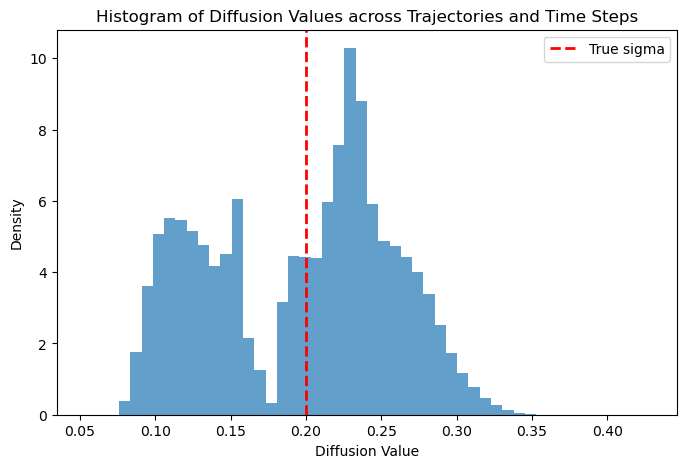

In [45]:
# Cell 8: Estimate sigma via Monte Carlo simulation of diffusion values

def simulate_diffusion(model, S0, MC_samples, n_steps, period_length=16):
    """
    Simulates trajectories using the trained Neural SDE and records the diffusion values at each time step.
    Returns an array of shape (MC_samples, n_steps) containing diffusion values.
    """
    model.eval()  # switch to evaluation mode
    diffusion_vals = []  # will store diffusion values per time step
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    
    # Loop through each time step and record the diffusion values
    for i in range(1, n_steps+1):
        idx = (i-1) // period_length
        t = torch.ones_like(S_old) * timegrid[i-1]
        # Compute diffusion value from the trained diffusion network
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy()/S_old.detach().cpu().numpy())
        
        # Simulate the SDE step (same as in the forward method)
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h/(1 + r_value * S_old.detach()*torch.sqrt(h)) \
                     + S_old * diffusion * dW/(1 + S_old.detach()*diffusion.detach()*torch.sqrt(h))
        S_old = S_new
    
    # Stack diffusion values from each time step: shape (MC_samples, n_steps)
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    return diffusion_vals

# Use a moderate number of trajectories for the simulation
MC_samples_sim = 1000000
diff_vals = simulate_diffusion(model, S0, MC_samples_sim, n_steps, period_length=30)

# Compute the Monte Carlo estimate of sigma: average of all diffusion values
estimated_sigma = np.mean(diff_vals)
print("Estimated sigma from neural SDE (MC average of diffusion values):", estimated_sigma)
print("True sigma:", sigma_value)

# Optional: Plot a histogram of the diffusion values to visualize the distribution
plt.figure(figsize=(8,5))
plt.hist(diff_vals.flatten(), bins=50, density=True, alpha=0.7)
plt.axvline(sigma_value, color='red', linestyle='dashed', linewidth=2, label='True sigma')
plt.xlabel("Diffusion Value")
plt.ylabel("Density")
plt.title("Histogram of Diffusion Values across Trajectories and Time Steps")
plt.legend()
plt.show()


beta = 1.00, Estimated sigma = 0.2031, Relative error = 0.0157
beta = 1.05, Estimated sigma = 0.2027, Relative error = 0.0133
beta = 1.10, Estimated sigma = 0.2021, Relative error = 0.0107
beta = 1.15, Estimated sigma = 0.2018, Relative error = 0.0091
beta = 1.21, Estimated sigma = 0.2023, Relative error = 0.0115
beta = 1.26, Estimated sigma = 0.2024, Relative error = 0.0119
beta = 1.31, Estimated sigma = 0.2021, Relative error = 0.0106
beta = 1.36, Estimated sigma = 0.2022, Relative error = 0.0109
beta = 1.41, Estimated sigma = 0.2028, Relative error = 0.0138
beta = 1.46, Estimated sigma = 0.2020, Relative error = 0.0099
beta = 1.51, Estimated sigma = 0.2032, Relative error = 0.0160
beta = 1.56, Estimated sigma = 0.2025, Relative error = 0.0126
beta = 1.62, Estimated sigma = 0.2024, Relative error = 0.0118
beta = 1.67, Estimated sigma = 0.2025, Relative error = 0.0125
beta = 1.72, Estimated sigma = 0.2029, Relative error = 0.0143
beta = 1.77, Estimated sigma = 0.2023, Relative error =

/tmp/ipykernel_165134/3728087811.py:32: RuntimeWarning: invalid value encountered in power
  paths[:, i] = S_prev + r * S_prev * dt + sigma_true * (S_prev ** beta) * dW
/tmp/ipykernel_165134/3728087811.py:57: RuntimeWarning: invalid value encountered in power
  norm_factor = (S_prev ** (beta - 1)) * np.sqrt(dt)
/tmp/ipykernel_165134/3728087811.py:32: RuntimeWarning: overflow encountered in power
  paths[:, i] = S_prev + r * S_prev * dt + sigma_true * (S_prev ** beta) * dW
/tmp/ipykernel_165134/3728087811.py:32: RuntimeWarning: invalid value encountered in add
  paths[:, i] = S_prev + r * S_prev * dt + sigma_true * (S_prev ** beta) * dW
/tmp/ipykernel_165134/3728087811.py:56: RuntimeWarning: invalid value encountered in subtract
  residual = np.abs(S_curr - S_prev - r * S_prev * dt)  # approximate diffusion increment
/tmp/ipykernel_165134/3728087811.py:57: RuntimeWarning: overflow encountered in square
  norm_factor = (S_prev ** (beta - 1)) * np.sqrt(dt)
/tmp/ipykernel_165134/3728087811

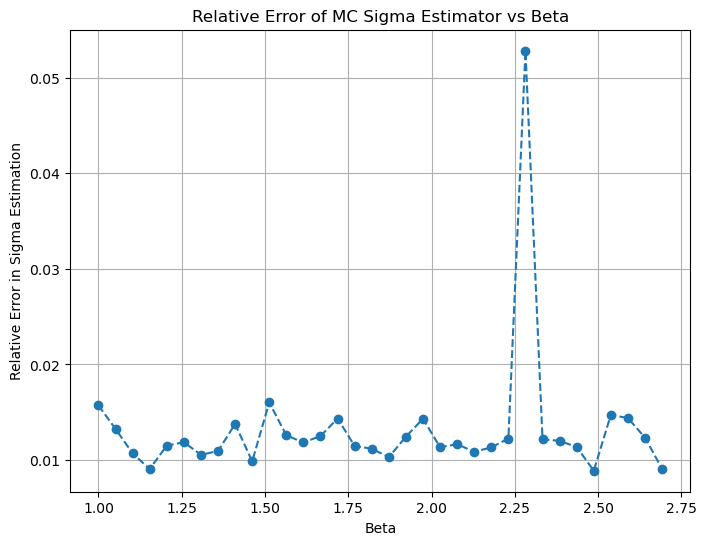

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Helper functions for MC simulation
# -------------------------------

def simulate_cev_paths(S0, r, sigma_true, beta, dt, n_steps, MC_samples):
    """
    Simulates sample paths for the CEV process:
      dS_t = r * S_t dt + sigma_true * S_t^beta dW_t,
    using an Euler discretization.
    
    Parameters:
      S0: initial asset price.
      r: risk-free rate.
      sigma_true: true sigma parameter.
      beta: elasticity parameter.
      dt: time step.
      n_steps: number of time steps.
      MC_samples: number of Monte Carlo paths.
    
    Returns:
      paths: NumPy array of shape (MC_samples, n_steps+1)
    """
    paths = np.zeros((MC_samples, n_steps+1))
    paths[:, 0] = S0
    for i in range(1, n_steps+1):
        dW = np.random.randn(MC_samples) * np.sqrt(dt)
        S_prev = paths[:, i-1]
        # Euler update for CEV process.
        paths[:, i] = S_prev + r * S_prev * dt + sigma_true * (S_prev ** beta) * dW
    return paths

def estimate_sigma_from_paths(paths, r, beta, dt):
    """
    Estimates sigma from simulated paths using the MC estimator:
      sigma_est = sqrt(pi/2) * average(|ΔS - r S dt| / (S^(beta-1)*sqrt(dt))).
    
    Parameters:
      paths: simulated paths of shape (MC_samples, n_steps+1).
      r: risk-free rate.
      beta: candidate beta.
      dt: time step.
      
    Returns:
      sigma_est: estimated sigma.
    """
    MC_samples, n_steps_plus = paths.shape
    n_steps = n_steps_plus - 1
    # Collect ratios for all steps and paths.
    ratio_list = []
    for i in range(1, n_steps+1):
        S_prev = paths[:, i-1]
        S_curr = paths[:, i]
        residual = np.abs(S_curr - S_prev - r * S_prev * dt)  # approximate diffusion increment
        norm_factor = (S_prev ** (beta - 1)) * np.sqrt(dt)
        ratio = residual / norm_factor
        ratio_list.append(ratio)
    ratio_all = np.concatenate(ratio_list)
    sigma_est = np.mean(ratio_all) * np.sqrt(np.pi / 2)
    return sigma_est

# -------------------------------
# Simulation and error analysis over candidate beta values
# -------------------------------

S0 = 1.0
r = 0.025
sigma_true = 0.2
T = 1.0         # Time horizon in years.
n_steps = 96
dt = T / n_steps
MC_samples = 5000

# Define candidate beta values between 1 and 3.
beta_values = np.linspace(1, 3, 40)
relative_errors = []

for beta in beta_values:
    # Simulate MC sample paths for the process with candidate beta.
    paths = simulate_cev_paths(S0, r, sigma_true, beta, dt, n_steps, MC_samples)
    sigma_est = estimate_sigma_from_paths(paths, r, beta, dt)
    rel_error = np.abs(sigma_est - sigma_true) / sigma_true
    relative_errors.append(rel_error)
    print(f"beta = {beta:.2f}, Estimated sigma = {sigma_est:.4f}, Relative error = {rel_error:.4f}")

# Plot the relative error vs. beta.
plt.figure(figsize=(8,6))
plt.plot(beta_values, relative_errors, marker='o', linestyle='--')
plt.xlabel("Beta")
plt.ylabel("Relative Error in Sigma Estimation")
plt.title("Relative Error of MC Sigma Estimator vs Beta")
plt.grid(True)
plt.show()


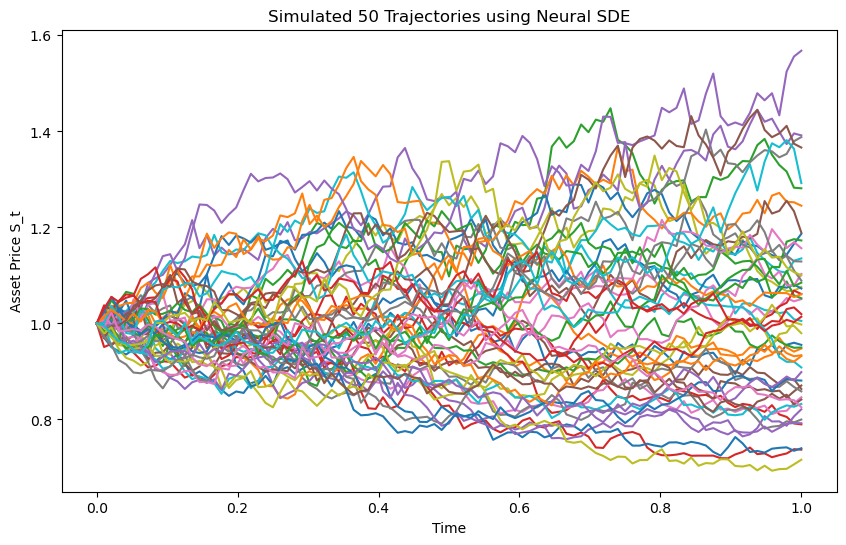

In [47]:
def simulate_paths(model, S0, MC_samples, n_steps, period_length=16):
    model.eval()  
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    paths = torch.zeros(MC_samples, n_steps+1, device=device)
    paths[:, 0] = S_old.squeeze(1)
    
    for i in range(1, n_steps+1):

        idx = min((i-1) // period_length, len(model.diffusion.net_t) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        h = timegrid[i] - timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h / (1 + r_value * S_old.detach() * torch.sqrt(h)) \
                    + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        paths[:, i] = S_new.squeeze(1)
        S_old = S_new
    return paths.detach().cpu().numpy()


MC_samples_sim_paths = 50
simulated_paths = simulate_paths(model, S0, MC_samples_sim_paths, n_steps, period_length=16)


time_points = timegrid.cpu().numpy()



plt.figure(figsize=(10, 6))
for i in range(MC_samples_sim_paths):
    plt.plot(time_points, simulated_paths[i, :], lw=1.5)
plt.xlabel("Time")
plt.ylabel("Asset Price S_t")
plt.title("Simulated 50 Trajectories using Neural SDE")
plt.show()


In [48]:
def predict_sigma_direct(model):

    t = torch.tensor([[timegrid[0]]], device=device)
    S_val = torch.tensor([[1.0]], device=device)
    sigma_pred = model.diffusion.forward_idx(0, torch.cat([t, S_val], 1))
    return sigma_pred.item()

def predict_sigma_via_trajectories(model, S0=1.0, n_steps=96, period_length=16, MC_samples=1000):

    model.eval()
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    diffusion_vals = []
    for i in range(1, n_steps+1):
        # Clamp index to ensure it does not exceed available networks
        idx = min((i-1) // period_length, len(model.diffusion.net_t) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + 0.025 * S_old * h / (1 + 0.025 * S_old.detach() * torch.sqrt(h)) \
                + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        S_old = S_new
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    sigma_traj = np.mean(diffusion_vals)
    return sigma_traj


=== Training model for sigma = 0.02 ===
Epoch: 0
Epoch 0: Hedge MSE = 0.0003, Hedge max error = 0.0982
Epoch 0: RMSE = 0.0008
Epoch: 1
Epoch 1: Hedge MSE = 0.0000, Hedge max error = 0.0484
Epoch 1: RMSE = 0.0008
Epoch: 2
Epoch 2: Hedge MSE = 0.0000, Hedge max error = 0.0243
Epoch 2: RMSE = 0.0002
Epoch: 3
Epoch 3: Hedge MSE = 0.0000, Hedge max error = 0.0259
Epoch 3: RMSE = 0.0002
Epoch: 4
Epoch 4: Hedge MSE = 0.0000, Hedge max error = 0.0228
Epoch 4: RMSE = 0.0002
Epoch: 5
Epoch 5: Hedge MSE = 0.0000, Hedge max error = 0.0236
Epoch 5: RMSE = 0.0002
Epoch: 6
Epoch 6: Hedge MSE = 0.0000, Hedge max error = 0.0234
Epoch 6: RMSE = 0.0002
Epoch: 7
Epoch 7: Hedge MSE = 0.0000, Hedge max error = 0.0240
Epoch 7: RMSE = 0.0002
Epoch: 8
Epoch 8: Hedge MSE = 0.0000, Hedge max error = 0.0245
Epoch 8: RMSE = 0.0002
Epoch: 9
Epoch 9: Hedge MSE = 0.0000, Hedge max error = 0.0247
Epoch 9: RMSE = 0.0002
Epoch: 10
Epoch 10: Hedge MSE = 0.0000, Hedge max error = 0.0252
Epoch 10: RMSE = 0.0002
Epoch: 11


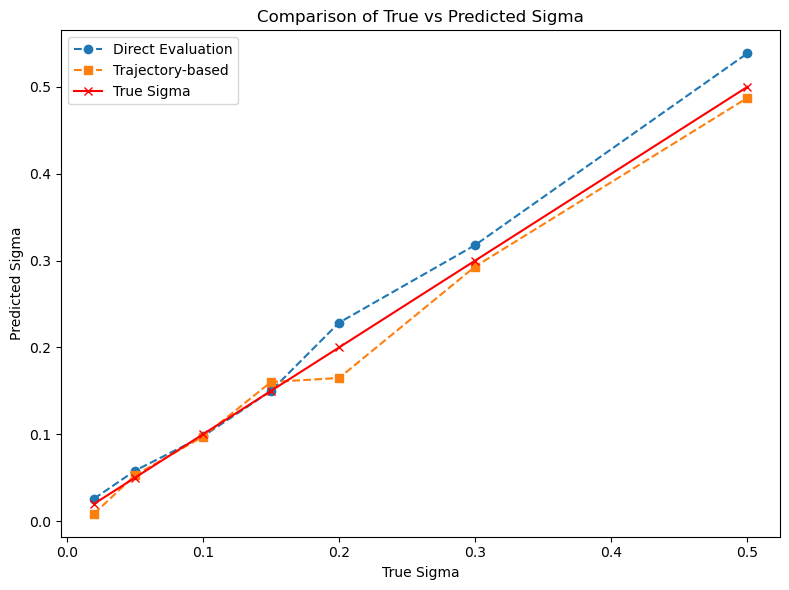

In [49]:
import numpy as np
from BS_generator import generate_option_prices  # Assumes BS_generator.py is in your folder
from networks import Net_timegrid                # Import helper network from networks.py


strikes_call = np.arange(0.8, 1.21, 0.02)
n_steps = 96
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
timegrid = torch.linspace(0, 1, n_steps+1).to(device)
maturities = list(range(16, 64, 16))  
n_maturities = len(maturities)
r_value = 0.025

MC_samples_test = 20000
z_test = torch.randn(MC_samples_test, n_steps, device=device)
z_test = torch.cat([z_test, -z_test], 0)

# ---- Missing functions ----

def predict_sigma_direct(model):
    """
    Direct evaluation: Apply t=0, S0=1 to the diffusion network (index 0).
    Returns the predicted sigma.
    """
    model.eval()
    input_tensor = torch.tensor([[0.0, 1.0]], device=device)
    sigma_pred = model.diffusion.forward_idx(0, input_tensor)
    return sigma_pred.item()

def simulate_diffusion(model, S0, MC_samples, n_steps, period_length=16):
    """
    Simulates trajectories using the trained Neural SDE model and records the diffusion values.
    Returns a numpy array of shape (MC_samples, n_steps) containing the diffusion values.
    """
    model.eval()
    diffusion_vals = []  
    ones = torch.ones(MC_samples, 1, device=device)
    S_old = ones * S0
    
    for i in range(1, n_steps+1):
        idx = min((i-1) // period_length, len(model.diffusion.net_t) - 1)
        t = torch.ones_like(S_old) * timegrid[i-1]
        diffusion = model.diffusion.forward_idx(idx, torch.cat([t, S_old], 1))
        diffusion_vals.append(diffusion.detach().cpu().numpy())
        
        h = timegrid[i] - timegrid[i-1]
        dW = torch.sqrt(h) * torch.randn(MC_samples, 1, device=device)
        S_new = S_old + r_value * S_old * h / (1 + r_value * S_old.detach() * torch.sqrt(h)) \
                    + S_old * diffusion * dW / (1 + S_old.detach() * diffusion.detach() * torch.sqrt(h))
        S_old = S_new
        
    diffusion_vals = np.concatenate(diffusion_vals, axis=1)
    return diffusion_vals

def predict_sigma_via_trajectories(model, S0, n_steps, period_length, MC_samples):
    """
    Simulates trajectories and estimates sigma as the Monte Carlo average of the diffusion values.
    """
    diff_vals = simulate_diffusion(model, S0, MC_samples, n_steps, period_length)
    sigma_estimate = np.mean(diff_vals)
    return sigma_estimate



sigmas = [0.02, 0.05, 0.1, 0.15, 0.2,  0.3, 0.5]
results_direct = {}
results_traj = {}


maturities_time = [timegrid[m].item() for m in maturities]

for sigma in sigmas:
    print(f"\n=== Training model for sigma = {sigma} ===")
    

    option_prices = generate_option_prices(1, r_value, sigma, maturities_time, strikes_call)
    
    CONFIG = {
        "batch_size": 1000,
        "n_epochs": 20,
        "maturities": maturities,        
        "n_maturities": n_maturities,
        "strikes_call": strikes_call,
        "timegrid": timegrid,
        "n_steps": n_steps,
        "target_data": option_prices,
    }
    

    model = Net_LV(dim=1, timegrid=timegrid, strikes_call=strikes_call, n_layers=5,
                   vNetWidth=50, device=device, n_maturities=n_maturities,
                   maturities=maturities, rate=r_value)
    model.to(device)
    model.apply(init_weights)
    

    z_test = torch.randn(20000, n_steps, device=device)
    z_test = torch.cat([z_test, -z_test], 0)
    

    model, _, _ = train_nsde(model, z_test, CONFIG)
    

    sigma_direct = predict_sigma_direct(model)
    results_direct[sigma] = sigma_direct
    print(f"Direct Evaluation --> True sigma: {sigma} \t Predicted sigma: {sigma_direct}")
    

    sigma_traj = predict_sigma_via_trajectories(model, S0=1.0, n_steps=n_steps, period_length=16, MC_samples=1000)
    results_traj[sigma] = sigma_traj
    print(f"Trajectory-based  --> True sigma: {sigma} \t Predicted sigma (averaged): {sigma_traj}")


true_sigmas = list(results_direct.keys())
predicted_direct = [results_direct[s] for s in true_sigmas]
predicted_traj = [results_traj[s] for s in true_sigmas]

plt.figure(figsize=(8, 6))
plt.plot(true_sigmas, predicted_direct, marker='o', linestyle='--', label="Direct Evaluation")
plt.plot(true_sigmas, predicted_traj, marker='s', linestyle='--', label="Trajectory-based")
plt.plot(true_sigmas, true_sigmas, marker='x', color='red', label="True Sigma")
plt.xlabel("True Sigma")
plt.ylabel("Predicted Sigma")
plt.title("Comparison of True vs Predicted Sigma")
plt.legend()
plt.tight_layout()
plt.show()

